# Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader as DL
from torch.utils.data import Dataset
from torch.nn.utils import weight_norm as WN
import torch.nn.functional as F

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score

from time import time
import random as r

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
n_folds = 4

sc_X = StandardScaler()

# Helper Functions

In [2]:
def breaker():
    print("\n" + 30*"-" + "\n")

def head(x, no_of_ele=5):
    breaker()
    print(x[:no_of_ele])
    breaker()

# Data Handling

In [3]:
dataset = pd.read_csv("../input/heart-disease-uci/heart.csv")

breaker()
print(dataset.shape)
breaker()

X = dataset.iloc[:, :-1].copy().values
y = dataset.iloc[:, -1].copy().values

X = sc_X.fit_transform(X)
num_features = X.shape[1]
num_obs_test = X.shape[0]

del dataset


------------------------------

(303, 14)

------------------------------



**Dataset Template**

In [4]:
class DS(Dataset):
    def __init__(this, X=None, y=None, mode="train"):
        this.X = X
        this.mode = mode
        if mode == "train":
            this.y = y
        
    def __len__(this):
        return this.X.shape[0]
    
    def __getitem__(this, idx):
        if this.mode == "train":
            return torch.FloatTensor(this.X[idx]), torch.FloatTensor(this.y[idx])
        else:
            return torch.FloatTensor(this.X[idx])

# ANN

**Config**

In [5]:
class ANN_CFG():
    batch_size = 64
    epochs = 50
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    IL = num_features
    HL = [128, 128]
    OL = 1
    
cfg = ANN_CFG()

**Setup**

In [6]:
class ANN(nn.Module):
    def __init__(this, IL=None, HL=None, OL=None):
        super(ANN, this).__init__()
        
        this.DP_1 = nn.Dropout(p=0.2)
        this.DP_2 = nn.Dropout(p=0.5)
        
        this.BN1 = nn.BatchNorm1d(IL)
        this.FC1 = WN(nn.Linear(IL, HL[0]))
        
        this.BN2 = nn.BatchNorm1d(HL[0])
        this.FC2 = WN(nn.Linear(HL[0], HL[1]))
        
        this.BN3 = nn.BatchNorm1d(HL[1])
        this.FC3 = WN(nn.Linear(HL[1], OL))
    
    def getOptimizer(this):
        return optim.Adam(this.parameters(), lr=1e-3, weight_decay=0)
    
    def forward(this, x):
        x = this.BN1(x)
        x = F.relu(this.FC1(x))
        x = this.BN2(x)
        x = F.relu(this.FC2(x))
        x = this.BN3(x)
        x = torch.sigmoid(this.FC3(x))
        return x

**ANN Helpers**

In [7]:
def train_fn(X=None, y=None, n_folds=None):
    breaker()
    print("Training...")
    LP = []
    name_getter = []
    fold = 0
    bestLoss = {"train" : np.inf, "valid" : np.inf}
    
    start_time = time()
    breaker()
    for tr_idx, va_idx in KFold(n_splits=n_folds, shuffle=True, random_state=0).split(X, y):
        print("Processing Fold {fold} ...".format(fold=fold+1))
        X_train, X_valid, y_train, y_valid = X[tr_idx], X[va_idx], y[tr_idx], y[va_idx]
        
        tr_data_setup = DS(X_train, y_train.reshape(-1,1))
        va_data_setup = DS(X_valid, y_valid.reshape(-1,1))
        
        dataloaders = {"train" : DL(tr_data_setup, batch_size=cfg.batch_size, shuffle=True, generator=torch.manual_seed(0)),
                       "valid" : DL(va_data_setup, batch_size=cfg.batch_size, shuffle=False)
                      }
        
        torch.manual_seed(0)
        model = ANN(cfg.IL, cfg.HL, cfg.OL)
        model.to(cfg.device)
        
        optimizer = model.getOptimizer()
        
        for e in range(cfg.epochs):
            epochLoss = {"train" : 0, "valid" : 0}
            for phase in ["train", "valid"]:
                if phase == "train":
                    model.train()
                else:
                    model.eval()
                lossPerPass = 0
                
                for feat, lbls in dataloaders[phase]:
                    feat, lbls = feat.to(cfg.device), lbls.to(cfg.device)
                    
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == "train"):
                        output = model(feat)
                        loss   = nn.BCELoss()(output, lbls)
                        if phase == "train":
                            loss.backward()
                            optimizer.step()
                    lossPerPass += (loss.item()/lbls.shape[0])
                epochLoss[phase] = lossPerPass
            LP.append(epochLoss)
            if epochLoss["valid"] < bestLoss["valid"]:
                bestLoss = epochLoss
                name = "./Model_Fold_{fold}.pt".format(fold=fold)
                name_getter.append(name)
                torch.save(model.state_dict(), name)
        fold += 1
    
    breaker()
    print("Time taken to train {fold} folds for {e} epochs : {:.2f} minutes".format((time()-start_time)/60, fold=n_folds, e=cfg.epochs))
    breaker()
    print("Best Loss :", repr(bestLoss))
    breaker()
    print("Training Complete")
    breaker()
    
    return LP, name_getter, model

def eval_fn(model=None, names=None, dataloader=None):
    final_Pred = np.zeros((num_obs_test, 1))
    
    for name in names:
        Pred = torch.zeros(cfg.batch_size, 1).to(cfg.device)
        model.load_state_dict(torch.load(name))
        model.eval()
        for X, y in dataloader:
            X = X.to(cfg.device)
            with torch.no_grad():
                Prob = model(X)
            Pred = torch.cat((Pred, Prob), dim=0)
        Pred = Pred[cfg.batch_size:]
        Pred = Pred.cpu().numpy()
        final_Pred = np.add(final_Pred, Pred)
        
    final_Pred = np.divide(final_Pred, len(names))
    final_Pred[np.argwhere(final_Pred > 0.5)[:, 0]]  = int(1)
    final_Pred[np.argwhere(final_Pred <= 0.5)[:, 0]] = int(0)
    return final_Pred.reshape(-1)

**Training**

In [8]:
LP, Names, Network = train_fn(X=X, y=y, n_folds=n_folds)


------------------------------

Training...

------------------------------

Processing Fold 1 ...
Processing Fold 2 ...
Processing Fold 3 ...
Processing Fold 4 ...

------------------------------

Time taken to train 4 folds for 50 epochs : 0.09 minutes

------------------------------

Best Loss : {'train': 0.0026517062115349937, 'valid': 0.01728107609475652}

------------------------------

Training Complete

------------------------------



**Plots**

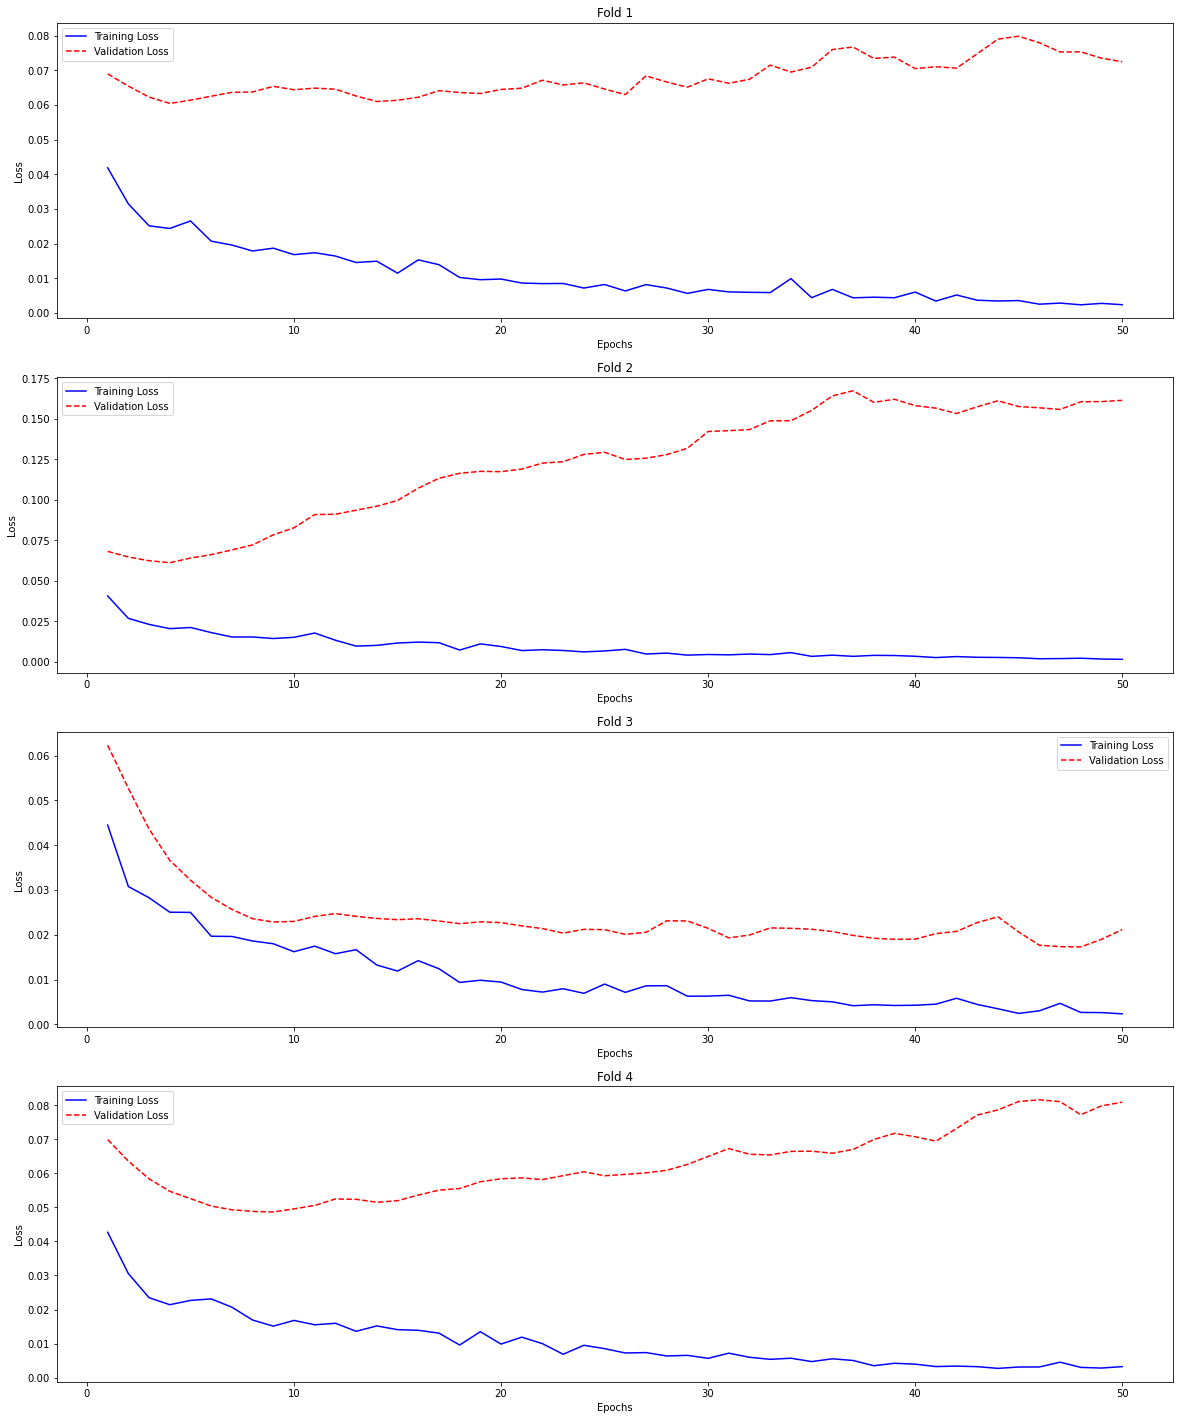

In [9]:
LPV = []
LPT = []
for i in range(len(LP)):
  LPT.append(LP[i]["train"])
  LPV.append(LP[i]["valid"])

xAxis = [i+1 for i in range(cfg.epochs)]
plt.figure(figsize=(20, 25))
for fold in range(n_folds):
    plt.subplot(n_folds, 1, fold+1)
    plt.plot(xAxis, LPT[fold*cfg.epochs:(fold+1)*cfg.epochs], "b", label="Training Loss")
    plt.plot(xAxis, LPV[fold*cfg.epochs:(fold+1)*cfg.epochs], "r--", label="Validation Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Fold {fold}".format(fold=fold+1))
plt.show()

**Evaluation**

In [10]:
ts_data_setup = DS(X, y.reshape(-1,1))
ts_data = DL(ts_data_setup, batch_size=cfg.batch_size, shuffle=False)

y_pred = eval_fn(Network, Names, ts_data)

breaker()
print("Accuracy : {:.5f} %".format(accuracy_score(y, y_pred) * 100))
breaker()


------------------------------

Accuracy : 95.70957 %

------------------------------

